In [53]:
# import dependencies
import os
import seaborn as sns
from datetime import datetime
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.tsatools import detrend

In [2]:
START = datetime(2016, 1, 1)
END = datetime(2021, 2, 16)
BUCKET = 1  # day

In [3]:
# Load data
global_markets_volumes_path = "data/VOLUMES.csv"
vix_path = "data/VIX.csv"
sp500_path = "data/SP500.csv"
gold_path= "data/GOLD.csv"
euro_usd_path = "data/EURUSD.csv"
bonds_path = "data/10YBONDYIELDS.csv"

In [4]:
def load_data(path: str, target:str) -> pd.DataFrame:
    assert target in ["gm", "vix", "sp500", "gold", "eurusd", "bonds"], f"Invaid target: {target}"

    root = os.path.dirname(os.getcwd())
    df = pd.read_csv(f"{root}/{path}")

    # rename columns to lower case
    df.columns = map(str.lower, df.columns)
    if target == "gm":
        index = "business date"
    else:
        index = "date"
    new_columns = ["date"] + [column + f"_{target}" for column in df.columns if column != index]
    # Add _target to columns except Date
    df.rename(columns=dict(zip(df.columns, new_columns)),inplace=True)
    # Remove space from columns
    df.columns = df.columns.str.replace(" ", "_")
    return df.set_index("date")

def join_dfs(df_list: List) -> pd.DataFrame:
    pdf = df_list[0]
    for df in df_list[1:]:
        pdf = pdf.join(df, how="left")
    assert len(pdf) == len(df_list[0])
    return pdf

In [5]:
gm_volumes = load_data(global_markets_volumes_path, "gm")
vix = load_data(vix_path, "vix")
sp500 = load_data(sp500_path, "sp500")
gold = load_data(gold_path, "gold")
euro_usd = load_data(euro_usd_path, "eurusd")
bonds = load_data(bonds_path, "bonds")

In [6]:
all_dfs = [gm_volumes, vix, sp500, gold, euro_usd, bonds]
all_data = join_dfs(all_dfs)
all_data

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,volume_bonds
date,,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245,0.0
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248,0.0
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177,0.0
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153,0.0
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130,0.0
...,...,...,...,...,...,...,...,...,...
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.133,0.0
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.158,0.0
2/12/2021,3232.310708,19.97,3934.830078,4.119260e+09,1821.599976,259.0,1.2108,1.200,0.0


In [7]:
# Remove bonds
data_no_bond_vol = all_data.drop(columns="volume_bonds")
data_no_bond_vol

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds
date,,,,,,,,
1/4/2016,1364.873049,20.70,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.245
1/5/2016,4826.624586,19.34,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.248
1/6/2016,1751.952884,20.59,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.177
1/7/2016,5842.829025,24.99,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.153
1/8/2016,1592.794266,27.01,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.130
...,...,...,...,...,...,...,...,...
2/10/2021,3190.066116,21.99,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.133
2/11/2021,2427.720356,21.25,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.158
2/12/2021,3232.310708,19.97,3934.830078,4.119260e+09,1821.599976,259.0,1.2108,1.200


In [9]:
data_no_bond_vol[data_no_bond_vol.isna().any(axis=1)]

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds
date,,,,,,,,
1/18/2016,1245.635545,NaN,NaN,NaN,NaN,NaN,1.0892,NaN
2/15/2016,1070.457234,NaN,NaN,NaN,NaN,NaN,1.1180,NaN
3/25/2016,2.655447,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3/28/2016,28.294602,15.24,2037.050049,2.809090e+09,1219.900024,33.0,NaN,1.87
5/30/2016,484.661910,NaN,NaN,NaN,NaN,NaN,1.1139,NaN
...,...,...,...,...,...,...,...,...
11/26/2020,3013.808951,NaN,NaN,NaN,NaN,NaN,1.1900,NaN
11/27/2020,3520.232596,20.84,3638.350098,2.778450e+09,NaN,NaN,1.1922,NaN
12/24/2020,936.569447,21.53,3703.060059,1.885090e+09,NaN,NaN,1.2193,NaN


TODO:
- Add target values
- Remove trend from gold price and sp price
- Add lag 1, 2 and/or 3 to volume
- Split in train, test
- Log transform volume_gm and vix
- Create baseline movng average model
- Train ML model
- Deploy

In [10]:
interpolated_data = data_no_bond_vol.interpolate()
interpolated_data

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds
date,,,,,,,,
1/4/2016,1364.873049,20.700,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.2450
1/5/2016,4826.624586,19.340,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.2480
1/6/2016,1751.952884,20.590,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.1770
1/7/2016,5842.829025,24.990,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.1530
1/8/2016,1592.794266,27.010,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.1300
...,...,...,...,...,...,...,...,...
2/10/2021,3190.066116,21.990,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.1330
2/11/2021,2427.720356,21.250,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.1580
2/12/2021,3232.310708,19.970,3934.830078,4.119260e+09,1821.599976,259.0,1.2108,1.2000


In [57]:
def get_train_test_indexes(df: pd.DataFrame, test_size: float):
    test_len = int(df.shape[0] * test_size)
    train_len = int(df.shape[0] - test_len)

    train_indexes = list(range(train_len))
    test_indexes = list(range(train_len, df.shape[0]))
    return train_indexes, test_indexes

def remove_trend(df):
    pass


def remove_seasonality(df):
    pass

In [35]:
# Add target values
interpolated_data_reduced = interpolated_data[interpolated_data["volume_gm"] != 1000]
interpolated_data_reduced["target"] = interpolated_data_reduced["volume_gm"].shift(-1)
interpolated_data_reduced = interpolated_data_reduced.iloc[:-1]
interpolated_data_reduced

/var/folders/hg/wkh3wd0x2cdgx68tgss9y0cr0000gn/T/ipykernel_97106/1002491583.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interpolated_data_reduced["target"] = interpolated_data_reduced["volume_gm"].shift(-1)


,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,target
date,,,,,,,,,
1/4/2016,1364.873049,20.700,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.2450,4826.624586
1/5/2016,4826.624586,19.340,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.2480,1751.952884
1/6/2016,1751.952884,20.590,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.1770,5842.829025
1/7/2016,5842.829025,24.990,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.1530,1592.794266
1/8/2016,1592.794266,27.010,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.1300,1692.648636
...,...,...,...,...,...,...,...,...,...
2/9/2021,2457.683556,21.630,3911.229980,4.554610e+09,1835.300049,184.0,1.2104,1.1570,3190.066116
2/10/2021,3190.066116,21.990,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.1330,2427.720356
2/11/2021,2427.720356,21.250,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.1580,3232.310708


In [44]:
# Remove trend from sp and gold
interpolated_data_reduced["adj_close_sp500_detrend"] = detrend(interpolated_data_reduced['adj_close_sp500'], order=1) #linear
interpolated_data_reduced["adj_close_gold_detrend"] = detrend(interpolated_data_reduced['adj_close_gold'], order=1) #linear
interpolated_data_reduced

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds,target,adj_close_sp500_detrend,adj_close_gold_detrend
date,,,,,,,,,,,
1/4/2016,1364.873049,20.700,2012.660034,4.304880e+09,1075.099976,143.0,1.0898,2.2450,4826.624586,59.963938,-13.571093
1/5/2016,4826.624586,19.340,2016.709961,3.706620e+09,1078.400024,82.0,1.0746,2.2480,1751.952884,62.839331,-10.738448
1/6/2016,1751.952884,20.590,1990.260010,4.336660e+09,1091.900024,52.0,1.0742,2.1770,5842.829025,35.214846,2.294148
1/7/2016,5842.829025,24.990,1943.089966,5.076590e+09,1107.699951,122.0,1.0868,2.1530,1592.794266,-13.129732,17.626672
1/8/2016,1592.794266,27.010,1922.030029,4.664940e+09,1097.800049,98.0,1.0861,2.1300,1692.648636,-35.364203,7.259367
...,...,...,...,...,...,...,...,...,...,...,...
2/9/2021,2457.683556,21.630,3911.229980,4.554610e+09,1835.300049,184.0,1.2104,1.1570,3190.066116,456.304830,148.820403
2/10/2021,3190.066116,21.990,3909.879883,4.815380e+09,1840.599976,543.0,1.2127,1.1330,2427.720356,453.780199,153.652927
2/11/2021,2427.720356,21.250,3916.379883,4.570080e+09,1824.900024,602.0,1.2147,1.1580,3232.310708,459.105665,137.485571


<Axes: xlabel='date'>

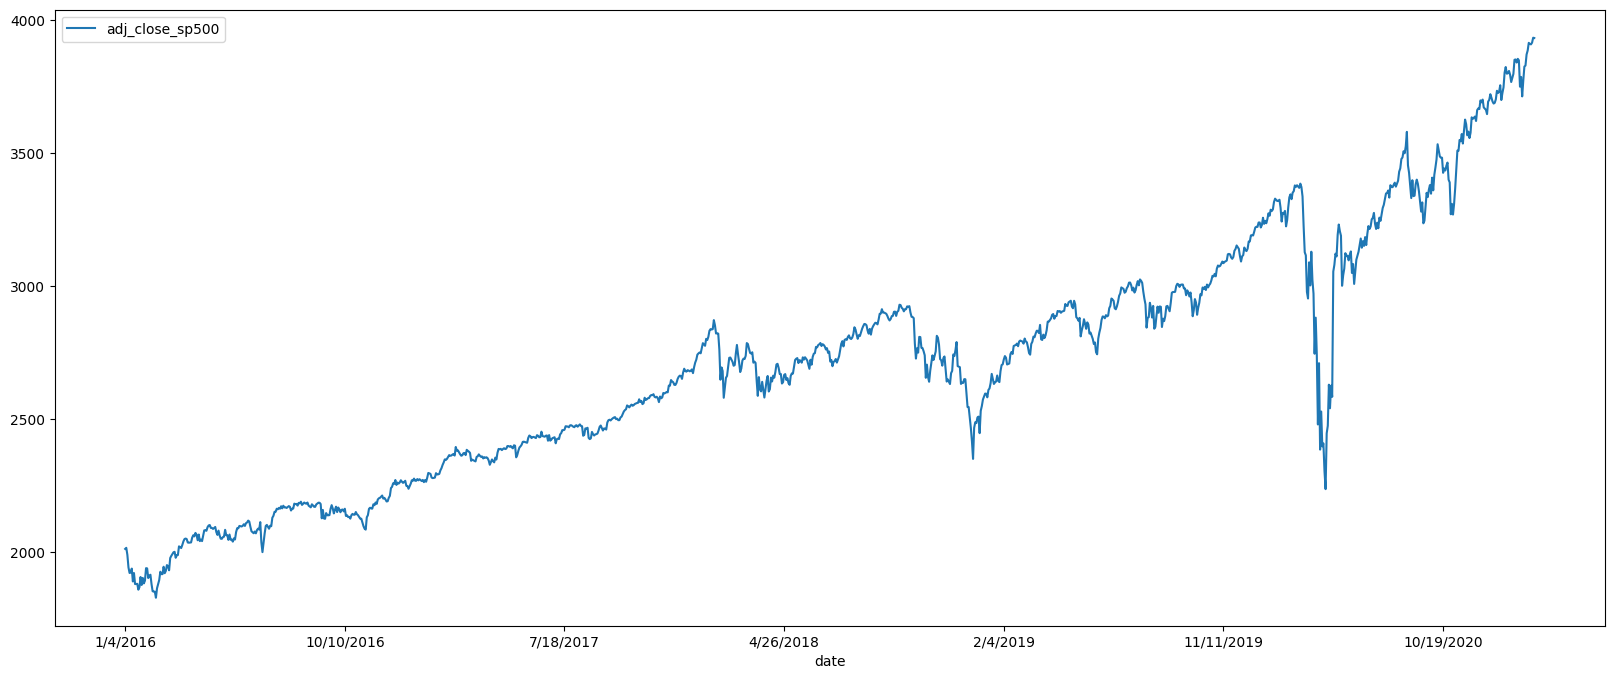

In [46]:
interpolated_data_reduced.plot(y='adj_close_sp500', figsize=[20, 8])

<Axes: xlabel='date'>

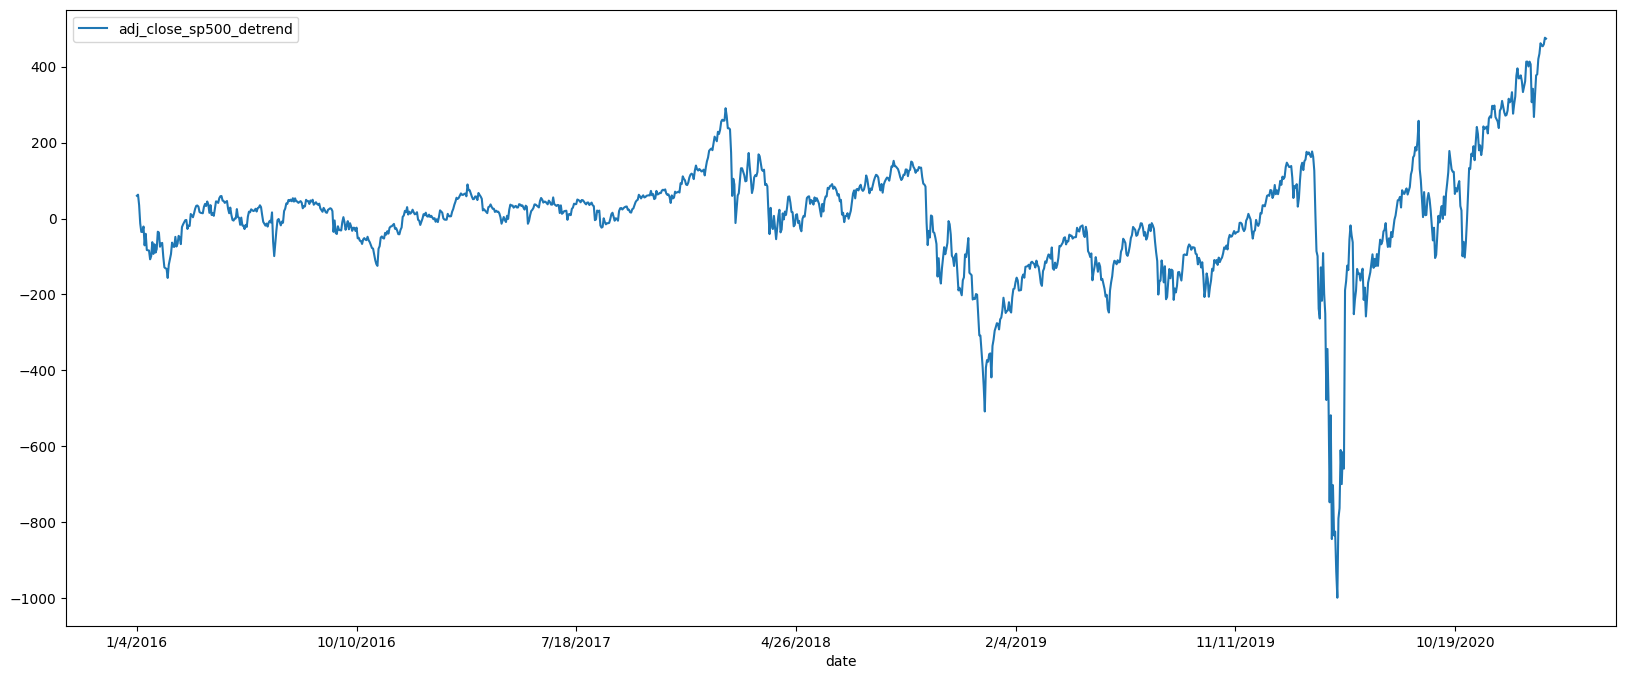

In [45]:
interpolated_data_reduced.plot(y='adj_close_sp500_detrend', figsize=[20, 8])

<Axes: xlabel='date'>

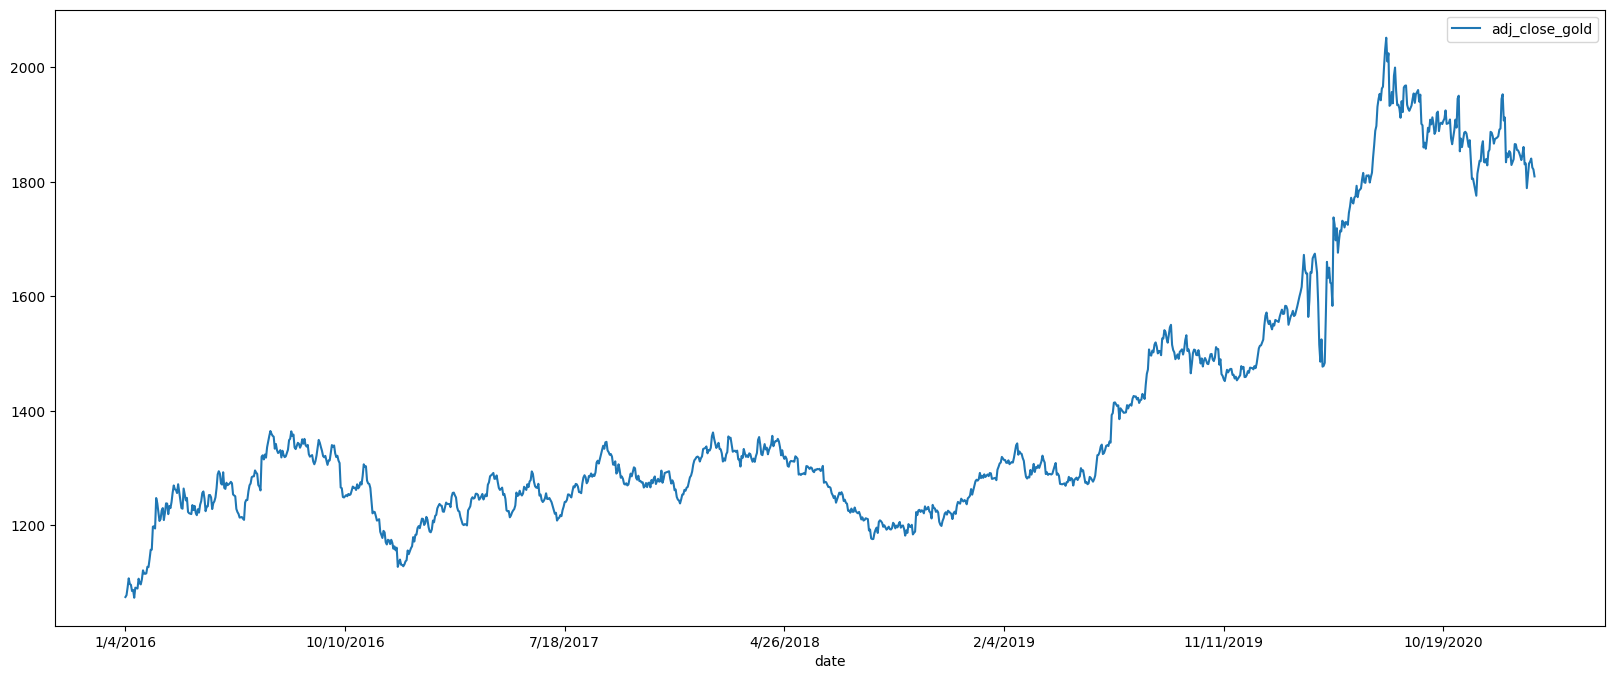

In [47]:
interpolated_data_reduced.plot(y='adj_close_gold', figsize=[20, 8])

<Axes: xlabel='date'>

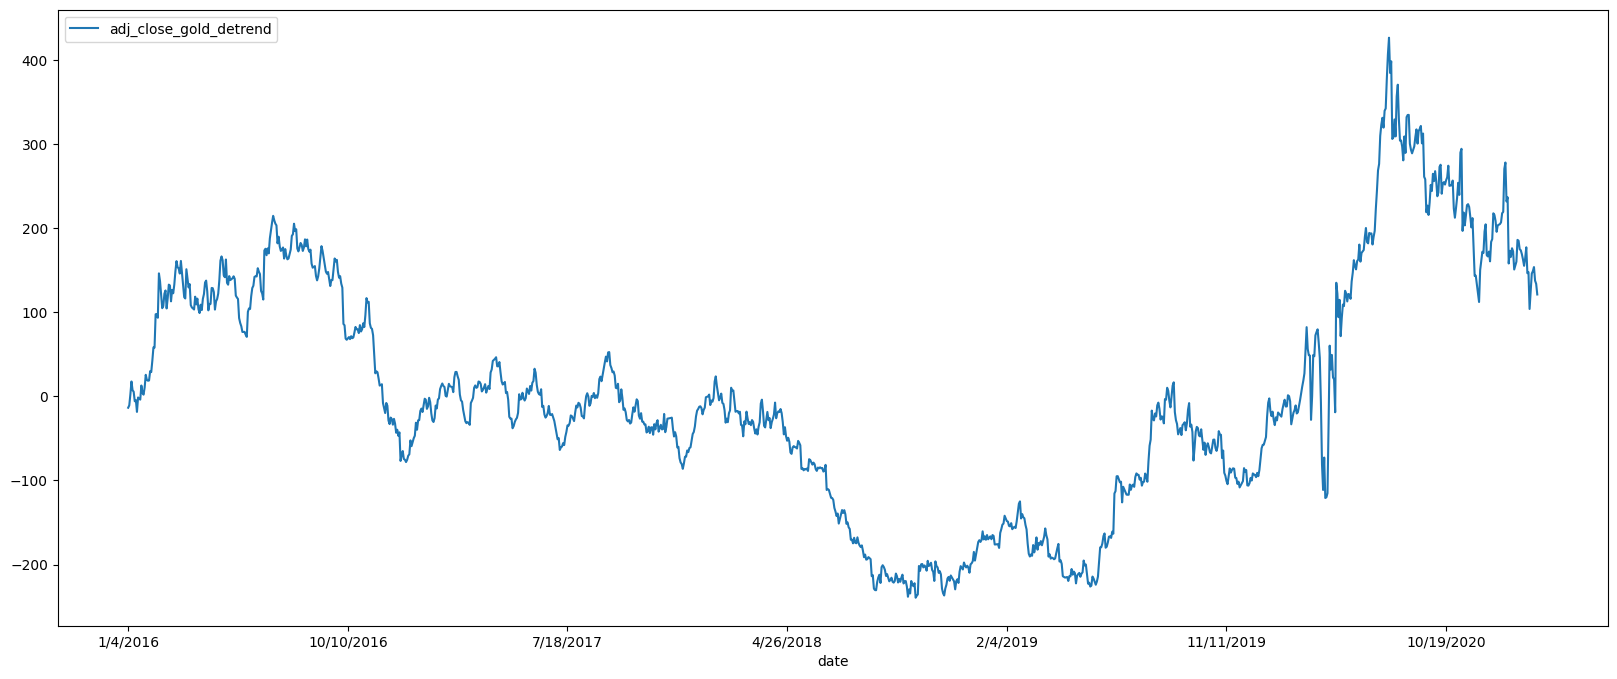

In [48]:
interpolated_data_reduced.plot(y='adj_close_gold_detrend', figsize=[20, 8])

In [58]:
# Get train and test indexes
train_indexes, test_indexes = get_train_test_indexes(interpolated_data_reduced, test_size=0.2)

                            Unobserved Components Results                            
Dep. Variable:                             y   No. Observations:                 1284
Model:                       fixed intercept   Log Likelihood              -16878.799
                   + stochastic seasonal(40)   AIC                          33759.597
Date:                       Wed, 08 May 2024   BIC                          33764.723
Time:                               14:10:39   HQIC                         33761.525
Sample:                                    0                                         
                                      - 1284                                         
Covariance Type:                         opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
sigma2.seasonal   1.57e+10   3.62e+08     43.382      0.00

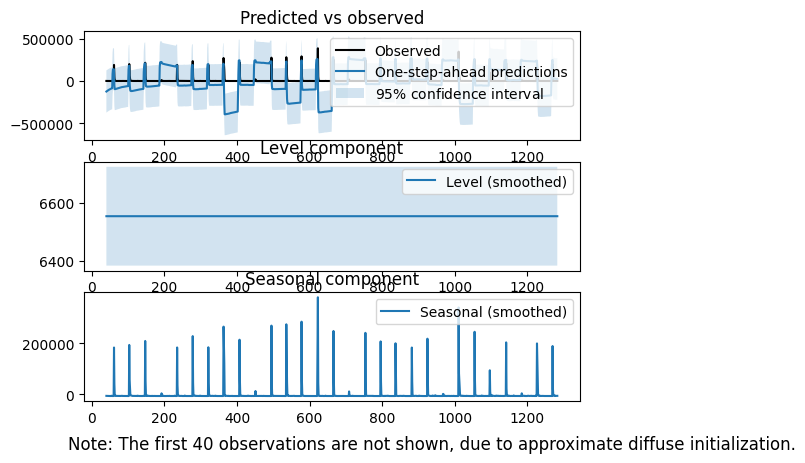

In [51]:
model = sm.tsa.UnobservedComponents(interpolated_data_reduced["volume_gold"].values,
                                    level='fixed intercept',
                                    seasonal=40)
res_f = model.fit(disp=False)
print(res_f.summary())
# The first state variable holds our estimate of the intercept
print("fixed intercept estimated as {0:.3f}".format(res_f.smoother_results.smoothed_state[0,-1:][0]))

res_f.plot_components()
plt.show()

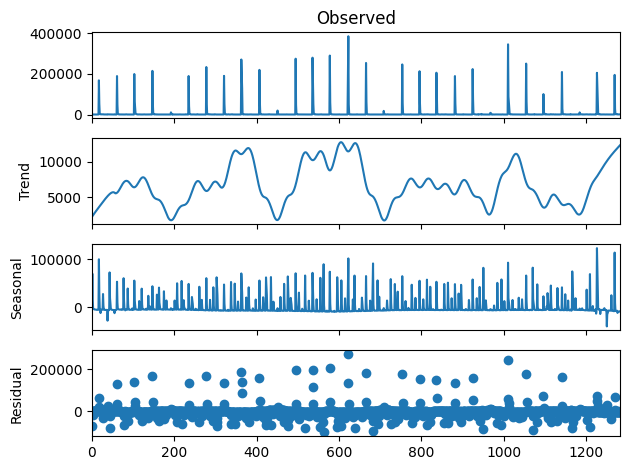

In [69]:
stl_gold = STL(interpolated_data_reduced["volume_gold"].values, period=60)
res_gold = stl_gold.fit()
fig = res_gold.plot()

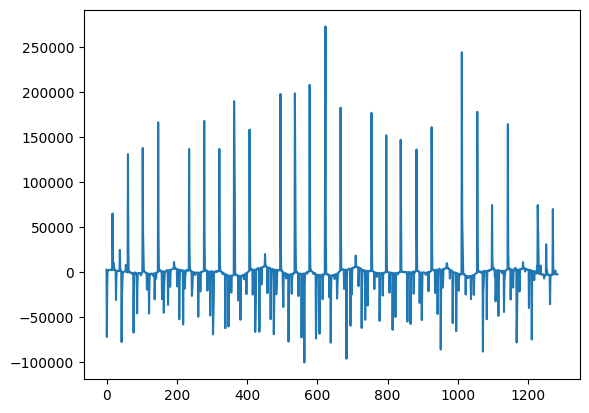

In [70]:
plt.plot(res_gold.resid)

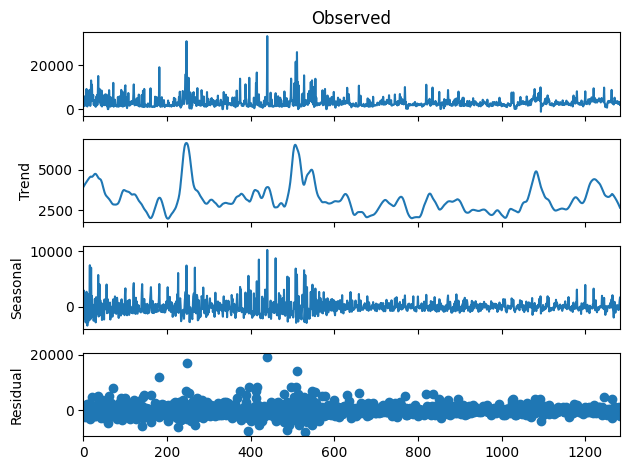

In [56]:
stl = STL(interpolated_data_reduced["volume_gm"].values, period=20)
res = stl.fit()
fig = res.plot()

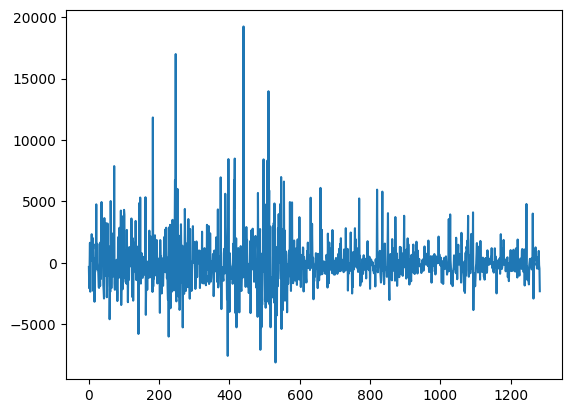

In [66]:
plt.plot(res.resid)


In [ ]:
train_df = interpolated_data_reduced.iloc[train_indexes]
test_df = interpolated_data_reduced.iloc[test_indexes]

<Axes: xlabel='date'>

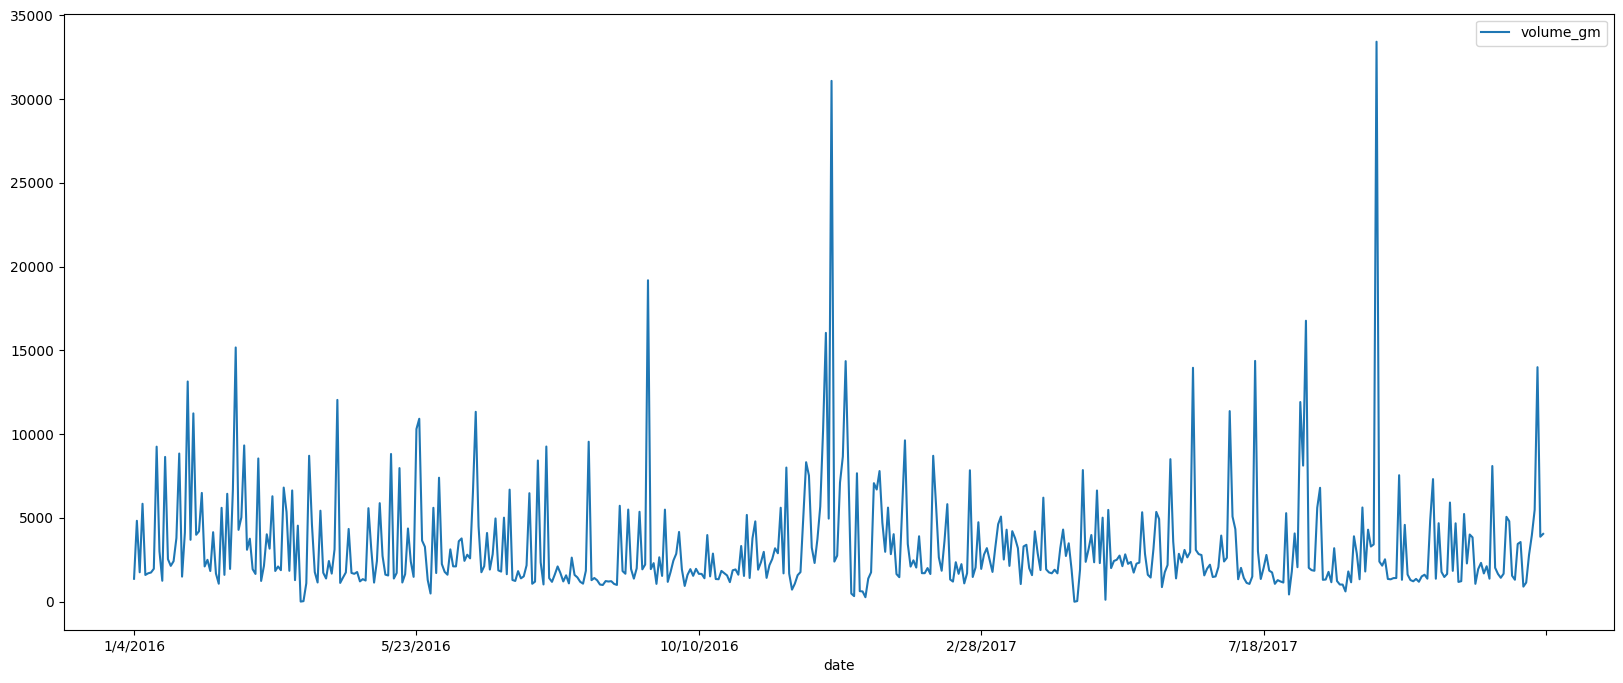

In [37]:
train_df.iloc[:500].plot(y='volume_gm', figsize=[20, 8])

<Axes: xlabel='date'>

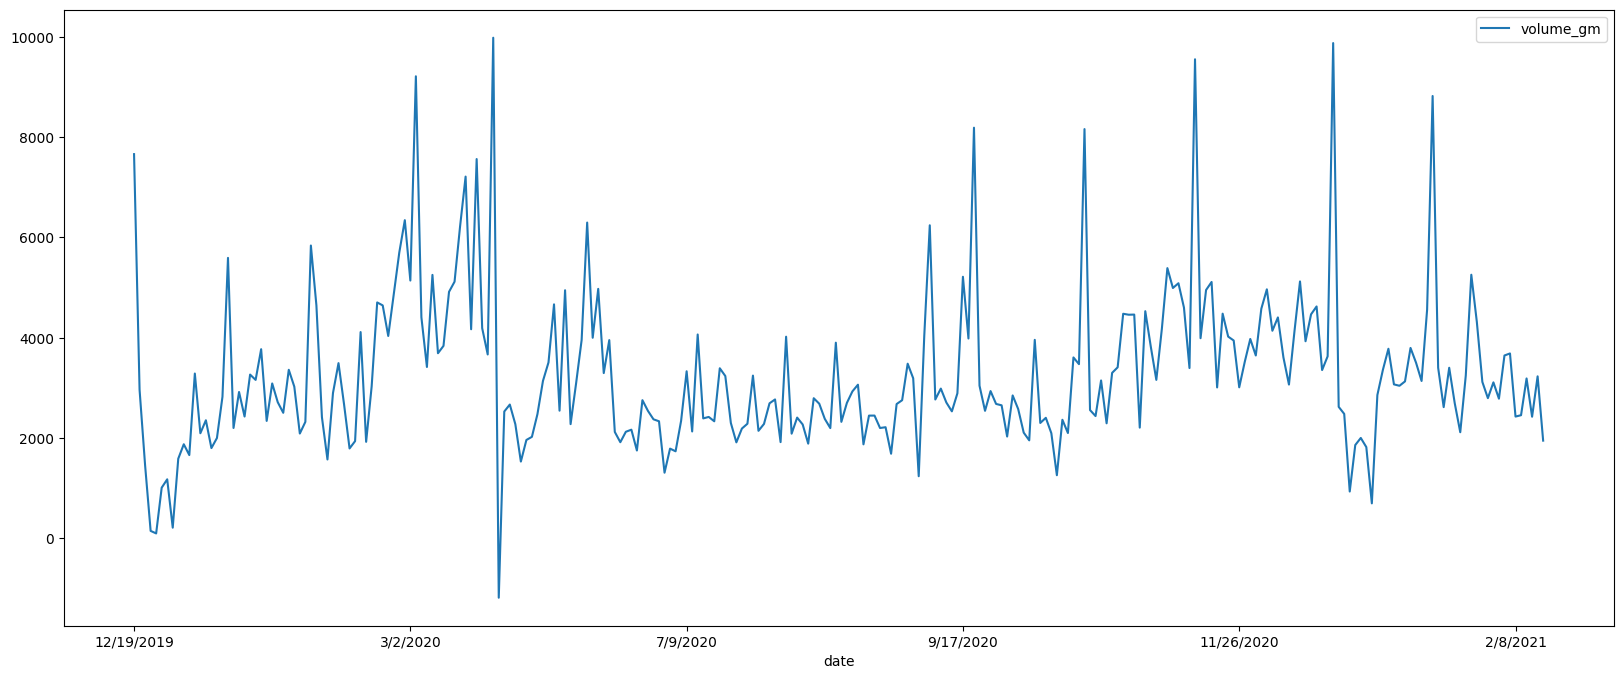

In [38]:
test_df.plot(y='volume_gm', figsize=[20, 8])

In [23]:
interpolated_data_reduced.iloc[test_indexes]

,volume_gm,vix_close_vix,adj_close_sp500,volume_sp500,adj_close_gold,volume_gold,usd_eurusd,adj_close_bonds
date,,,,,,,,
12/19/2019,7661.701953,12.500,3205.370117,3.720450e+09,1478.199951,319.0,1.11170,1.9080
12/20/2019,2963.764072,12.510,3221.219971,6.454270e+09,1474.699951,118.0,1.10970,1.9170
12/23/2019,1458.084698,12.610,3224.010010,3.060610e+09,1482.500000,391.0,1.10750,1.9350
12/24/2019,151.678597,12.670,3223.379883,1.296540e+09,1495.900024,258.5,1.10800,1.9200
12/26/2019,101.194918,12.650,3239.909912,2.160680e+09,1509.300049,126.0,1.11165,1.9050
...,...,...,...,...,...,...,...,...
2/10/2021,3190.066116,21.990,3909.879883,4.815380e+09,1840.599976,543.0,1.21270,1.1330
2/11/2021,2427.720356,21.250,3916.379883,4.570080e+09,1824.900024,602.0,1.21470,1.1580
2/12/2021,3232.310708,19.970,3934.830078,4.119260e+09,1821.599976,259.0,1.21080,1.2000
